In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from torchvision import models, datasets, transforms
import numpy as np
from tqdm import tqdm
import time
import os
import subprocess
import codecarbon
from thop import profile

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data augmentations for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training data into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

# Define Custom ResNet-50 Model
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(CustomResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# Initialize model
teacher_model = CustomResNet50().to(device)

# Define loss function, optimizer, and learning rate scheduler
criterion_ce = nn.CrossEntropyLoss()
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer_teacher, mode='min', factor=0.1, patience=5, verbose=True)

# Use CodeCarbon for energy consumption tracking
tracker = codecarbon.EmissionsTracker()
tracker.start()

# Function to get GPU power consumption using nvidia-smi
def get_gpu_power():
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,nounits,noheader'],
            stdout=subprocess.PIPE, text=True
        )
        power_draws = [float(p) for p in result.stdout.strip().split('\n')]
        return sum(power_draws) / len(power_draws) if power_draws else 0.0
    except Exception as e:
        print(f"Error getting GPU power: {e}")
        return 0.0

gpu_power_readings = []

# Training loop
num_epochs_teacher = 80
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_accuracy = 0.0
best_val_loss = float('inf')
start_training_time = time.time()

for epoch in range(num_epochs_teacher):
    teacher_model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs_teacher}] - Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_teacher.zero_grad()
        outputs = teacher_model(inputs)
        loss = criterion_ce(outputs, labels)
        loss.backward()
        optimizer_teacher.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
        gpu_power_readings.append(get_gpu_power())

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    teacher_model.eval()
    running_val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = teacher_model(inputs)
            loss = criterion_ce(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs_teacher}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(teacher_model.state_dict(), 'best_teacher_model.pth')

    scheduler.step(val_loss)

training_time = time.time() - start_training_time

# Stop the CodeCarbon tracker
emissions = tracker.stop()

# Model analysis metrics
param_count = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
model_size = os.path.getsize('best_teacher_model.pth') / (1024 * 1024)

# FLOPs calculation
example_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(teacher_model, inputs=(example_input,), verbose=False)

# Inference time calculation
teacher_model.eval()
inference_start = time.time()
with torch.no_grad():
    for _ in range(100):  # Measure inference time over 100 iterations
        _ = teacher_model(example_input)
inference_time = (time.time() - inference_start) / 100  # Average inference time per run

# Report energy and performance metrics
avg_gpu_power = sum(gpu_power_readings) / len(gpu_power_readings) if gpu_power_readings else 0.0
energy_consumption_gpu = (avg_gpu_power * num_epochs_teacher * len(train_loader) / 1000)

# Final results
print("\n--- Model Analysis ---")
print(f"Parameter Count: {param_count}")
print(f"Model Size: {model_size:.2f} MB")
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Average Inference Time: {inference_time:.6f} seconds")

print("\n--- Energy and Emissions Report ---")
print(f"CO2 Emissions: {emissions:.6f} kg")
print(f"Average GPU Power Consumption: {avg_gpu_power:.2f} W")
print(f"Total GPU Energy Consumption: {energy_consumption_gpu:.6f} kWh")


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[codecarbon INFO @ 01:23:11] [setup] RAM Tracking...
[codecarbon INFO @ 01:23:11] [setup] GPU Tracking...
[codecarbon INFO @ 01:23:11] Tracking Nvidia GPU via pynvml
[codecarbon INFO @

Epoch [1/80], Train Loss: 1.2898, Train Acc: 55.48%, Val Loss: 1.1446, Val Acc: 60.70%


Epoch [2/80] - Training:  23%|██▎       | 73/313 [00:12<00:55,  4.29it/s][codecarbon INFO @ 01:24:27] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:24:27] Energy consumed for all GPUs : 0.001037 kWh. Total GPU Power : 50.69144286276493 W
[codecarbon INFO @ 01:24:27] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:24:27] 0.002022 kWh of electricity used since the beginning.
Epoch [2/80] - Training:  53%|█████▎    | 166/313 [00:27<00:33,  4.44it/s][codecarbon INFO @ 01:24:42] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:24:42] Energy consumed for all GPUs : 0.001268 kWh. Total GPU Power : 55.286366791853794 W
[codecarbon INFO @ 01:24:42] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:24:42] 0.002449 kWh of electricity used since the beginning.
Epoch [2/80] - Training:  81%|████████▏ | 255/313 [00:42<00:

Epoch [2/80], Train Loss: 1.1287, Train Acc: 61.80%, Val Loss: 1.3379, Val Acc: 62.26%


Epoch [3/80] - Training:  18%|█▊        | 56/313 [00:10<01:01,  4.15it/s][codecarbon INFO @ 01:25:27] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:25:27] Energy consumed for all GPUs : 0.001897 kWh. Total GPU Power : 48.32903499783744 W
[codecarbon INFO @ 01:25:27] Energy consumed for all CPUs : 0.001595 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:25:27] 0.003670 kWh of electricity used since the beginning.
Epoch [3/80] - Training:  47%|████▋     | 146/313 [00:25<00:38,  4.34it/s][codecarbon INFO @ 01:25:42] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:25:42] Energy consumed for all GPUs : 0.002128 kWh. Total GPU Power : 55.70756473136611 W
[codecarbon INFO @ 01:25:42] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:25:42] 0.004097 kWh of electricity used since the beginning.
Epoch [3/80] - Training:  76%|███████▌  | 237/313 [00:40<00:1

Epoch [3/80], Train Loss: 1.0075, Train Acc: 65.91%, Val Loss: 0.8632, Val Acc: 70.53%


Epoch [4/80] - Training:  12%|█▏        | 39/313 [00:08<00:54,  5.04it/s][codecarbon INFO @ 01:26:27] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:26:27] Energy consumed for all GPUs : 0.002754 kWh. Total GPU Power : 42.79935460845958 W
[codecarbon INFO @ 01:26:27] Energy consumed for all CPUs : 0.002303 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:26:27] 0.005314 kWh of electricity used since the beginning.
Epoch [4/80] - Training:  41%|████      | 129/313 [00:23<00:30,  6.13it/s][codecarbon INFO @ 01:26:42] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:26:42] Energy consumed for all GPUs : 0.002985 kWh. Total GPU Power : 55.264604688211065 W
[codecarbon INFO @ 01:26:42] Energy consumed for all CPUs : 0.002480 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:26:42] 0.005742 kWh of electricity used since the beginning.
Epoch [4/80] - Training:  70%|██████▉   | 219/313 [00:38<00:

Epoch [4/80], Train Loss: 0.9478, Train Acc: 68.34%, Val Loss: 0.8524, Val Acc: 70.61%


Epoch [5/80] - Training:   7%|▋         | 23/313 [00:06<00:45,  6.44it/s][codecarbon INFO @ 01:27:27] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:27:27] Energy consumed for all GPUs : 0.003621 kWh. Total GPU Power : 40.55636116648439 W
[codecarbon INFO @ 01:27:27] Energy consumed for all CPUs : 0.003012 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:27:27] 0.006969 kWh of electricity used since the beginning.
Epoch [5/80] - Training:  36%|███▌      | 113/313 [00:20<00:32,  6.21it/s][codecarbon INFO @ 01:27:42] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:27:42] Energy consumed for all GPUs : 0.003848 kWh. Total GPU Power : 54.67914663885241 W
[codecarbon INFO @ 01:27:42] Energy consumed for all CPUs : 0.003189 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:27:42] 0.007393 kWh of electricity used since the beginning.
Epoch [5/80] - Training:  65%|██████▌   | 204/313 [00:35<00:1

Epoch [5/80], Train Loss: 0.8144, Train Acc: 72.13%, Val Loss: 0.7685, Val Acc: 73.38%


Epoch [6/80] - Training:   3%|▎         | 10/313 [00:02<00:48,  6.22it/s][codecarbon INFO @ 01:28:27] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:28:27] Energy consumed for all GPUs : 0.004483 kWh. Total GPU Power : 42.5227116175515 W
[codecarbon INFO @ 01:28:27] Energy consumed for all CPUs : 0.003720 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:28:27] 0.008619 kWh of electricity used since the beginning.
Epoch [6/80] - Training:  32%|███▏      | 100/313 [00:17<00:31,  6.86it/s][codecarbon INFO @ 01:28:42] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:28:42] Energy consumed for all GPUs : 0.004712 kWh. Total GPU Power : 54.92529352633517 W
[codecarbon INFO @ 01:28:42] Energy consumed for all CPUs : 0.003897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:28:43] 0.009044 kWh of electricity used since the beginning.
Epoch [6/80] - Training:  61%|██████    | 190/313 [00:32<00:18

Epoch [6/80], Train Loss: 0.7945, Train Acc: 72.92%, Val Loss: 0.7850, Val Acc: 73.10%


Epoch [7/80] - Training:   0%|          | 0/313 [00:00<?, ?it/s][codecarbon INFO @ 01:29:28] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:29:28] Energy consumed for all GPUs : 0.005359 kWh. Total GPU Power : 44.167001431865565 W
[codecarbon INFO @ 01:29:28] Energy consumed for all CPUs : 0.004429 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:29:28] 0.010283 kWh of electricity used since the beginning.
Epoch [7/80] - Training:  27%|██▋       | 86/313 [00:15<00:33,  6.68it/s][codecarbon INFO @ 01:29:43] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:29:43] Energy consumed for all GPUs : 0.005579 kWh. Total GPU Power : 52.76317614385036 W
[codecarbon INFO @ 01:29:43] Energy consumed for all CPUs : 0.004606 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:29:43] 0.010700 kWh of electricity used since the beginning.
Epoch [7/80] - Training:  56%|█████▌    | 174/313 [00:30<00:20,  6.79i

Epoch [7/80], Train Loss: 0.7627, Train Acc: 73.94%, Val Loss: 0.8039, Val Acc: 73.06%


Epoch [8/80] - Training:  20%|██        | 63/313 [00:12<00:34,  7.29it/s][codecarbon INFO @ 01:30:43] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:30:43] Energy consumed for all GPUs : 0.006431 kWh. Total GPU Power : 47.32976420312806 W
[codecarbon INFO @ 01:30:43] Energy consumed for all CPUs : 0.005315 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:30:43] 0.012340 kWh of electricity used since the beginning.
Epoch [8/80] - Training:  49%|████▉     | 154/313 [00:27<00:22,  6.92it/s][codecarbon INFO @ 01:30:58] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:30:58] Energy consumed for all GPUs : 0.006661 kWh. Total GPU Power : 55.11352974818235 W
[codecarbon INFO @ 01:30:58] Energy consumed for all CPUs : 0.005492 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:30:58] 0.012766 kWh of electricity used since the beginning.
Epoch [8/80] - Training:  78%|███████▊  | 244/313 [00:42<00:1

Epoch [8/80], Train Loss: 0.7561, Train Acc: 74.51%, Val Loss: 0.7345, Val Acc: 74.67%


Epoch [9/80] - Training:  15%|█▍        | 46/313 [00:09<00:40,  6.51it/s][codecarbon INFO @ 01:31:43] Energy consumed for all GPUs : 0.007285 kWh. Total GPU Power : 42.31149273212766 W
[codecarbon INFO @ 01:31:43] Energy consumed for all CPUs : 0.006024 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:31:43] 0.013982 kWh of electricity used since the beginning.
Epoch [9/80] - Training:  43%|████▎     | 135/313 [00:24<00:26,  6.82it/s][codecarbon INFO @ 01:31:58] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:31:58] Energy consumed for all GPUs : 0.007508 kWh. Total GPU Power : 53.639664254394425 W
[codecarbon INFO @ 01:31:58] Energy consumed for all CPUs : 0.006201 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:31:58] 0.014401 kWh of electricity used since the beginning.
Epoch [9/80] - Training:  72%|███████▏  | 225/313 [00:39<00:12,  7.01it/s][codecarbon INFO @ 01:32:13] Energy consumed for RAM : 0.000712 kWh. RAM Power : 4.75303

Epoch [9/80], Train Loss: 0.6979, Train Acc: 76.19%, Val Loss: 0.7145, Val Acc: 75.28%


Epoch [10/80] - Training:   8%|▊         | 25/313 [00:04<00:44,  6.52it/s][codecarbon INFO @ 01:32:43] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:32:43] Energy consumed for all GPUs : 0.008141 kWh. Total GPU Power : 41.452450256209886 W
[codecarbon INFO @ 01:32:43] Energy consumed for all CPUs : 0.006732 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:32:43] 0.015626 kWh of electricity used since the beginning.
Epoch [10/80] - Training:  37%|███▋      | 115/313 [00:19<00:27,  7.10it/s][codecarbon INFO @ 01:32:58] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:32:58] Energy consumed for all GPUs : 0.008366 kWh. Total GPU Power : 53.84487775041982 W
[codecarbon INFO @ 01:32:58] Energy consumed for all CPUs : 0.006910 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:32:58] 0.016048 kWh of electricity used since the beginning.
Epoch [10/80] - Training:  65%|██████▍   | 203/313 [00:34<

Epoch [10/80], Train Loss: 0.7009, Train Acc: 76.14%, Val Loss: 0.7642, Val Acc: 74.10%


Epoch [11/80] - Training:   2%|▏         | 7/313 [00:01<01:02,  4.87it/s][codecarbon INFO @ 01:33:43] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:33:43] Energy consumed for all GPUs : 0.008995 kWh. Total GPU Power : 41.84458019878304 W
[codecarbon INFO @ 01:33:43] Energy consumed for all CPUs : 0.007442 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:33:43] 0.017268 kWh of electricity used since the beginning.
Epoch [11/80] - Training:  32%|███▏      | 99/313 [00:16<00:30,  7.07it/s][codecarbon INFO @ 01:33:58] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:33:58] Energy consumed for all GPUs : 0.009219 kWh. Total GPU Power : 53.6390859394046 W
[codecarbon INFO @ 01:33:58] Energy consumed for all CPUs : 0.007618 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:33:58] 0.017688 kWh of electricity used since the beginning.
Epoch [11/80] - Training:  61%|██████    | 191/313 [00:31<00:1

Epoch [11/80], Train Loss: 0.6862, Train Acc: 76.83%, Val Loss: 0.8005, Val Acc: 72.89%


Epoch [12/80] - Training:   1%|          | 2/313 [00:00<02:15,  2.30it/s][codecarbon INFO @ 01:34:43] Energy consumed for RAM : 0.000910 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:34:43] Energy consumed for all GPUs : 0.009859 kWh. Total GPU Power : 43.13084502337169 W
[codecarbon INFO @ 01:34:43] Energy consumed for all CPUs : 0.008150 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:34:43] 0.018919 kWh of electricity used since the beginning.
Epoch [12/80] - Training:  29%|██▉       | 90/313 [00:15<00:33,  6.71it/s][codecarbon INFO @ 01:34:58] Energy consumed for RAM : 0.000930 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:34:58] Energy consumed for all GPUs : 0.010081 kWh. Total GPU Power : 53.437697290590854 W
[codecarbon INFO @ 01:34:58] Energy consumed for all CPUs : 0.008327 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:34:58] 0.019339 kWh of electricity used since the beginning.
Epoch [12/80] - Training:  57%|█████▋    | 179/313 [00:31<00

Epoch [12/80], Train Loss: 0.6810, Train Acc: 76.98%, Val Loss: 0.6875, Val Acc: 76.88%


Epoch [13/80] - Training:  22%|██▏       | 70/313 [00:13<00:36,  6.68it/s][codecarbon INFO @ 01:35:58] Energy consumed for RAM : 0.001009 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:35:58] Energy consumed for all GPUs : 0.010925 kWh. Total GPU Power : 47.69368300951959 W
[codecarbon INFO @ 01:35:58] Energy consumed for all CPUs : 0.009036 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:35:58] 0.020970 kWh of electricity used since the beginning.
Epoch [13/80] - Training:  51%|█████     | 159/313 [00:27<00:21,  7.02it/s][codecarbon INFO @ 01:36:13] Energy consumed for RAM : 0.001029 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:36:13] Energy consumed for all GPUs : 0.011152 kWh. Total GPU Power : 54.62316404391203 W
[codecarbon INFO @ 01:36:13] Energy consumed for all CPUs : 0.009213 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:36:13] 0.021395 kWh of electricity used since the beginning.
Epoch [13/80] - Training:  80%|███████▉  | 249/313 [00:42<0

Epoch [13/80], Train Loss: 0.6580, Train Acc: 77.85%, Val Loss: 0.6597, Val Acc: 77.18%


Epoch [14/80] - Training:  16%|█▋        | 51/313 [00:08<00:38,  6.75it/s][codecarbon INFO @ 01:36:58] Energy consumed for RAM : 0.001089 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:36:58] Energy consumed for all GPUs : 0.011786 kWh. Total GPU Power : 46.366586704737216 W
[codecarbon INFO @ 01:36:58] Energy consumed for all CPUs : 0.009745 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:36:58] 0.022619 kWh of electricity used since the beginning.
Epoch [14/80] - Training:  46%|████▋     | 145/313 [00:23<00:22,  7.35it/s][codecarbon INFO @ 01:37:13] Energy consumed for RAM : 0.001108 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:37:13] Energy consumed for all GPUs : 0.012017 kWh. Total GPU Power : 55.50087070395553 W
[codecarbon INFO @ 01:37:13] Energy consumed for all CPUs : 0.009922 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:37:13] 0.023047 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:37:13] 0.003795 g.CO2eq/s mean an es

Epoch [14/80], Train Loss: 0.6453, Train Acc: 78.30%, Val Loss: 0.6665, Val Acc: 77.32%


Epoch [15/80] - Training:  11%|█         | 34/313 [00:06<00:53,  5.18it/s][codecarbon INFO @ 01:37:58] Energy consumed for RAM : 0.001168 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:37:58] Energy consumed for all GPUs : 0.012645 kWh. Total GPU Power : 41.248657468168304 W
[codecarbon INFO @ 01:37:58] Energy consumed for all CPUs : 0.010454 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:37:58] 0.024267 kWh of electricity used since the beginning.
Epoch [15/80] - Training:  39%|███▉      | 123/313 [00:21<00:37,  5.01it/s][codecarbon INFO @ 01:38:13] Energy consumed for RAM : 0.001188 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:38:13] Energy consumed for all GPUs : 0.012865 kWh. Total GPU Power : 53.152370211672455 W
[codecarbon INFO @ 01:38:13] Energy consumed for all CPUs : 0.010631 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:38:13] 0.024684 kWh of electricity used since the beginning.
Epoch [15/80] - Training:  69%|██████▊   | 215/313 [00:36

Epoch [15/80], Train Loss: 0.6246, Train Acc: 78.81%, Val Loss: 0.6393, Val Acc: 78.32%


Epoch [16/80] - Training:   6%|▌         | 18/313 [00:04<01:07,  4.38it/s][codecarbon INFO @ 01:38:58] Energy consumed for RAM : 0.001247 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:38:58] Energy consumed for all GPUs : 0.013500 kWh. Total GPU Power : 42.18191260708424 W
[codecarbon INFO @ 01:38:58] Energy consumed for all CPUs : 0.011163 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:38:58] 0.025910 kWh of electricity used since the beginning.
Epoch [16/80] - Training:  35%|███▍      | 108/313 [00:18<00:44,  4.63it/s][codecarbon INFO @ 01:39:13] Energy consumed for RAM : 0.001267 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:39:13] Energy consumed for all GPUs : 0.013727 kWh. Total GPU Power : 54.54356770546818 W
[codecarbon INFO @ 01:39:13] Energy consumed for all CPUs : 0.011340 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:39:13] 0.026333 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:39:13] 0.003795 g.CO2eq/s mean an est

Epoch [16/80], Train Loss: 0.6081, Train Acc: 79.21%, Val Loss: 0.6673, Val Acc: 77.75%


Epoch [17/80] - Training:   2%|▏         | 5/313 [00:01<01:34,  3.27it/s][codecarbon INFO @ 01:39:58] Energy consumed for RAM : 0.001326 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:39:58] Energy consumed for all GPUs : 0.014361 kWh. Total GPU Power : 41.66450099372745 W
[codecarbon INFO @ 01:39:58] Energy consumed for all CPUs : 0.011871 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:39:58] 0.027558 kWh of electricity used since the beginning.
Epoch [17/80] - Training:  30%|██▉       | 93/313 [00:16<00:46,  4.74it/s][codecarbon INFO @ 01:40:13] Energy consumed for RAM : 0.001346 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:40:13] Energy consumed for all GPUs : 0.014578 kWh. Total GPU Power : 52.09911696824401 W
[codecarbon INFO @ 01:40:13] Energy consumed for all CPUs : 0.012049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:40:13] 0.027972 kWh of electricity used since the beginning.
Epoch [17/80] - Training:  58%|█████▊    | 182/313 [00:31<00:

Epoch [17/80], Train Loss: 0.6069, Train Acc: 79.50%, Val Loss: 0.6272, Val Acc: 78.25%


Epoch [18/80] - Training:  25%|██▍       | 77/313 [00:13<00:52,  4.48it/s][codecarbon INFO @ 01:41:13] Energy consumed for RAM : 0.001425 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:41:13] Energy consumed for all GPUs : 0.015441 kWh. Total GPU Power : 52.586081827588686 W
[codecarbon INFO @ 01:41:13] Energy consumed for all CPUs : 0.012758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:41:13] 0.029625 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:41:13] 0.003799 g.CO2eq/s mean an estimation of 119.80015291312223 kg.CO2eq/year
Epoch [18/80] - Training:  53%|█████▎    | 167/313 [00:28<00:33,  4.37it/s][codecarbon INFO @ 01:41:28] Energy consumed for RAM : 0.001445 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:41:28] Energy consumed for all GPUs : 0.015673 kWh. Total GPU Power : 55.68786090538561 W
[codecarbon INFO @ 01:41:28] Energy consumed for all CPUs : 0.012935 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:41:28] 0.030053 

Epoch [18/80], Train Loss: 0.6107, Train Acc: 79.22%, Val Loss: 0.6284, Val Acc: 78.41%


Epoch [19/80] - Training:  21%|██        | 66/313 [00:11<00:59,  4.15it/s][codecarbon INFO @ 01:42:13] Energy consumed for RAM : 0.001504 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:42:13] Energy consumed for all GPUs : 0.016304 kWh. Total GPU Power : 49.698091601063766 W
[codecarbon INFO @ 01:42:13] Energy consumed for all CPUs : 0.013467 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:42:13] 0.031275 kWh of electricity used since the beginning.
Epoch [19/80] - Training:  50%|████▉     | 156/313 [00:26<00:37,  4.19it/s][codecarbon INFO @ 01:42:28] Energy consumed for RAM : 0.001524 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:42:28] Energy consumed for all GPUs : 0.016534 kWh. Total GPU Power : 55.46033438024574 W
[codecarbon INFO @ 01:42:28] Energy consumed for all CPUs : 0.013644 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:42:28] 0.031702 kWh of electricity used since the beginning.
Epoch [19/80] - Training:  79%|███████▊  | 246/313 [00:41<

Epoch [19/80], Train Loss: 0.5870, Train Acc: 79.97%, Val Loss: 0.6146, Val Acc: 79.03%


Epoch [20/80] - Training:  15%|█▍        | 46/313 [00:09<01:05,  4.10it/s][codecarbon INFO @ 01:43:13] Energy consumed for RAM : 0.001584 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:43:13] Energy consumed for all GPUs : 0.017158 kWh. Total GPU Power : 44.05497134086916 W
[codecarbon INFO @ 01:43:13] Energy consumed for all CPUs : 0.014175 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:43:14] 0.032917 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:43:14] 0.003802 g.CO2eq/s mean an estimation of 119.90022059918729 kg.CO2eq/year
Epoch [20/80] - Training:  43%|████▎     | 134/313 [00:24<00:43,  4.12it/s][codecarbon INFO @ 01:43:28] Energy consumed for RAM : 0.001603 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:43:28] Energy consumed for all GPUs : 0.017380 kWh. Total GPU Power : 53.66646848040851 W
[codecarbon INFO @ 01:43:28] Energy consumed for all CPUs : 0.014352 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:43:28] 0.033335 k

Epoch [20/80], Train Loss: 0.5899, Train Acc: 80.00%, Val Loss: 0.6204, Val Acc: 79.12%


Epoch [21/80] - Training:   9%|▉         | 28/313 [00:06<00:52,  5.48it/s][codecarbon INFO @ 01:44:14] Energy consumed for RAM : 0.001663 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:44:14] Energy consumed for all GPUs : 0.018005 kWh. Total GPU Power : 39.99064177126551 W
[codecarbon INFO @ 01:44:14] Energy consumed for all CPUs : 0.014883 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:44:14] 0.034551 kWh of electricity used since the beginning.
Epoch [21/80] - Training:  37%|███▋      | 117/313 [00:21<00:32,  6.03it/s][codecarbon INFO @ 01:44:29] Energy consumed for RAM : 0.001682 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:44:29] Energy consumed for all GPUs : 0.018233 kWh. Total GPU Power : 54.503932413372816 W
[codecarbon INFO @ 01:44:29] Energy consumed for all CPUs : 0.015060 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:44:29] 0.034975 kWh of electricity used since the beginning.
Epoch [21/80] - Training:  66%|██████▌   | 207/313 [00:36<

Epoch [21/80], Train Loss: 0.5689, Train Acc: 80.51%, Val Loss: 0.6387, Val Acc: 78.04%


Epoch [22/80] - Training:   4%|▎         | 11/313 [00:02<00:49,  6.10it/s][codecarbon INFO @ 01:45:14] Energy consumed for RAM : 0.001742 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:45:14] Energy consumed for all GPUs : 0.018867 kWh. Total GPU Power : 42.31105463027865 W
[codecarbon INFO @ 01:45:14] Energy consumed for all CPUs : 0.015592 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:14] 0.036201 kWh of electricity used since the beginning.
[codecarbon INFO @ 01:45:14] 0.003795 g.CO2eq/s mean an estimation of 119.68251862286053 kg.CO2eq/year
Epoch [22/80] - Training:  32%|███▏      | 100/313 [00:17<00:33,  6.33it/s][codecarbon INFO @ 01:45:29] Energy consumed for RAM : 0.001762 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:45:29] Energy consumed for all GPUs : 0.019088 kWh. Total GPU Power : 53.186467335930274 W
[codecarbon INFO @ 01:45:29] Energy consumed for all CPUs : 0.015769 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:45:29] 0.036619 

Epoch [22/80], Train Loss: 0.5615, Train Acc: 81.07%, Val Loss: 0.6730, Val Acc: 77.02%


Epoch [23/80] - Training:  25%|██▍       | 77/313 [00:14<00:32,  7.20it/s][codecarbon INFO @ 01:46:29] Energy consumed for RAM : 0.001841 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:46:29] Energy consumed for all GPUs : 0.019939 kWh. Total GPU Power : 50.46574793239083 W
[codecarbon INFO @ 01:46:29] Energy consumed for all CPUs : 0.016477 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:29] 0.038257 kWh of electricity used since the beginning.
Epoch [23/80] - Training:  54%|█████▎    | 168/313 [00:29<00:21,  6.89it/s][codecarbon INFO @ 01:46:44] Energy consumed for RAM : 0.001861 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:46:44] Energy consumed for all GPUs : 0.020172 kWh. Total GPU Power : 55.88222482252938 W
[codecarbon INFO @ 01:46:44] Energy consumed for all CPUs : 0.016654 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:46:44] 0.038687 kWh of electricity used since the beginning.
Epoch [23/80] - Training:  82%|████████▏ | 258/313 [00:44<0

Epoch [23/80], Train Loss: 0.5613, Train Acc: 80.82%, Val Loss: 0.6165, Val Acc: 78.70%


Epoch [24/80] - Training:  20%|██        | 64/313 [00:11<00:34,  7.23it/s][codecarbon INFO @ 01:47:29] Energy consumed for RAM : 0.001920 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:47:29] Energy consumed for all GPUs : 0.020806 kWh. Total GPU Power : 47.008241875825526 W
[codecarbon INFO @ 01:47:29] Energy consumed for all CPUs : 0.017186 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:29] 0.039912 kWh of electricity used since the beginning.
Epoch [24/80] - Training:  51%|█████     | 159/313 [00:26<00:19,  7.71it/s][codecarbon INFO @ 01:47:44] Energy consumed for RAM : 0.001940 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:47:44] Energy consumed for all GPUs : 0.021035 kWh. Total GPU Power : 54.99917101657436 W
[codecarbon INFO @ 01:47:44] Energy consumed for all CPUs : 0.017363 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:47:44] 0.040338 kWh of electricity used since the beginning.
Epoch [24/80] - Training:  81%|████████  | 254/313 [00:42<

Epoch [24/80], Train Loss: 0.5498, Train Acc: 81.21%, Val Loss: 0.6213, Val Acc: 78.40%


Epoch [25/80] - Training:  21%|██        | 65/313 [00:12<00:35,  7.05it/s][codecarbon INFO @ 01:48:29] Energy consumed for RAM : 0.001999 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:48:29] Energy consumed for all GPUs : 0.021678 kWh. Total GPU Power : 47.24099955347046 W
[codecarbon INFO @ 01:48:29] Energy consumed for all CPUs : 0.017895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:29] 0.041572 kWh of electricity used since the beginning.
Epoch [25/80] - Training:  50%|████▉     | 156/313 [00:27<00:22,  7.01it/s][codecarbon INFO @ 01:48:44] Energy consumed for RAM : 0.002019 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:48:44] Energy consumed for all GPUs : 0.021907 kWh. Total GPU Power : 54.98509057279036 W
[codecarbon INFO @ 01:48:44] Energy consumed for all CPUs : 0.018072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:48:44] 0.041998 kWh of electricity used since the beginning.
Epoch [25/80] - Training:  79%|███████▊  | 246/313 [00:42<0

Epoch [25/80], Train Loss: 0.5412, Train Acc: 81.64%, Val Loss: 0.5805, Val Acc: 80.24%


Epoch [26/80] - Training:  16%|█▌        | 50/313 [00:09<00:38,  6.80it/s][codecarbon INFO @ 01:49:29] Energy consumed for RAM : 0.002078 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:49:29] Energy consumed for all GPUs : 0.022536 kWh. Total GPU Power : 44.4340329734726 W
[codecarbon INFO @ 01:49:29] Energy consumed for all CPUs : 0.018603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:29] 0.043217 kWh of electricity used since the beginning.
Epoch [26/80] - Training:  45%|████▍     | 140/313 [00:24<00:25,  6.77it/s][codecarbon INFO @ 01:49:44] Energy consumed for RAM : 0.002098 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:49:44] Energy consumed for all GPUs : 0.022761 kWh. Total GPU Power : 54.19305895352616 W
[codecarbon INFO @ 01:49:44] Energy consumed for all CPUs : 0.018781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:49:44] 0.043640 kWh of electricity used since the beginning.
Epoch [26/80] - Training:  73%|███████▎  | 228/313 [00:39<00

Epoch [26/80], Train Loss: 0.5386, Train Acc: 81.65%, Val Loss: 0.5911, Val Acc: 79.79%


Epoch [27/80] - Training:  10%|▉         | 30/313 [00:05<00:40,  7.04it/s][codecarbon INFO @ 01:50:29] Energy consumed for RAM : 0.002157 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:50:29] Energy consumed for all GPUs : 0.023387 kWh. Total GPU Power : 42.45605932779415 W
[codecarbon INFO @ 01:50:29] Energy consumed for all CPUs : 0.019311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:29] 0.044856 kWh of electricity used since the beginning.
Epoch [27/80] - Training:  39%|███▊      | 121/313 [00:20<00:27,  6.90it/s][codecarbon INFO @ 01:50:44] Energy consumed for RAM : 0.002177 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:50:44] Energy consumed for all GPUs : 0.023617 kWh. Total GPU Power : 55.25614090210138 W
[codecarbon INFO @ 01:50:44] Energy consumed for all CPUs : 0.019488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:50:44] 0.045282 kWh of electricity used since the beginning.
Epoch [27/80] - Training:  67%|██████▋   | 210/313 [00:35<0

Epoch [27/80], Train Loss: 0.5311, Train Acc: 81.75%, Val Loss: 0.6036, Val Acc: 79.38%


Epoch [28/80] - Training:   4%|▍         | 14/313 [00:02<00:48,  6.12it/s][codecarbon INFO @ 01:51:29] Energy consumed for RAM : 0.002236 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:51:29] Energy consumed for all GPUs : 0.024242 kWh. Total GPU Power : 41.05565335885879 W
[codecarbon INFO @ 01:51:29] Energy consumed for all CPUs : 0.020020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:29] 0.046498 kWh of electricity used since the beginning.
Epoch [28/80] - Training:  33%|███▎      | 104/313 [00:17<00:31,  6.59it/s][codecarbon INFO @ 01:51:44] Energy consumed for RAM : 0.002256 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:51:44] Energy consumed for all GPUs : 0.024467 kWh. Total GPU Power : 54.04942074193018 W
[codecarbon INFO @ 01:51:44] Energy consumed for all CPUs : 0.020197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:51:44] 0.046920 kWh of electricity used since the beginning.
Epoch [28/80] - Training:  62%|██████▏   | 193/313 [00:32<0

Epoch [28/80], Train Loss: 0.5264, Train Acc: 82.06%, Val Loss: 0.5980, Val Acc: 79.43%


Epoch [29/80] - Training:   0%|          | 0/313 [00:00<?, ?it/s][codecarbon INFO @ 01:52:29] Energy consumed for RAM : 0.002315 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:52:29] Energy consumed for all GPUs : 0.025112 kWh. Total GPU Power : 44.915792467950716 W
[codecarbon INFO @ 01:52:29] Energy consumed for all CPUs : 0.020728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:29] 0.048155 kWh of electricity used since the beginning.
Epoch [29/80] - Training:  28%|██▊       | 88/313 [00:15<00:32,  6.98it/s][codecarbon INFO @ 01:52:44] Energy consumed for RAM : 0.002335 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:52:44] Energy consumed for all GPUs : 0.025331 kWh. Total GPU Power : 52.84986074953821 W
[codecarbon INFO @ 01:52:44] Energy consumed for all CPUs : 0.020905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:52:44] 0.048572 kWh of electricity used since the beginning.
Epoch [29/80] - Training:  57%|█████▋    | 178/313 [00:30<00:19,  7.

Epoch [29/80], Train Loss: 0.5217, Train Acc: 82.14%, Val Loss: 0.5978, Val Acc: 79.18%


Epoch [30/80] - Training:  25%|██▍       | 78/313 [00:13<00:32,  7.28it/s][codecarbon INFO @ 01:53:44] Energy consumed for RAM : 0.002414 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:53:44] Energy consumed for all GPUs : 0.026183 kWh. Total GPU Power : 49.54801129888492 W
[codecarbon INFO @ 01:53:44] Energy consumed for all CPUs : 0.021614 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:44] 0.050211 kWh of electricity used since the beginning.
Epoch [30/80] - Training:  55%|█████▍    | 172/313 [00:28<00:19,  7.10it/s][codecarbon INFO @ 01:53:59] Energy consumed for RAM : 0.002434 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:53:59] Energy consumed for all GPUs : 0.026417 kWh. Total GPU Power : 56.13210321501394 W
[codecarbon INFO @ 01:53:59] Energy consumed for all CPUs : 0.021791 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:53:59] 0.050642 kWh of electricity used since the beginning.
Epoch [30/80] - Training:  85%|████████▌ | 267/313 [00:43<0

Epoch [30/80], Train Loss: 0.5118, Train Acc: 82.44%, Val Loss: 0.5784, Val Acc: 80.28%


Epoch [31/80] - Training:  25%|██▍       | 78/313 [00:12<00:45,  5.15it/s][codecarbon INFO @ 01:54:44] Energy consumed for RAM : 0.002494 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:54:44] Energy consumed for all GPUs : 0.027065 kWh. Total GPU Power : 52.636048412303836 W
[codecarbon INFO @ 01:54:44] Energy consumed for all CPUs : 0.022323 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:44] 0.051881 kWh of electricity used since the beginning.
Epoch [31/80] - Training:  54%|█████▎    | 168/313 [00:27<00:31,  4.65it/s][codecarbon INFO @ 01:54:59] Energy consumed for RAM : 0.002513 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:54:59] Energy consumed for all GPUs : 0.027294 kWh. Total GPU Power : 55.19428334991237 W
[codecarbon INFO @ 01:54:59] Energy consumed for all CPUs : 0.022500 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:54:59] 0.052307 kWh of electricity used since the beginning.
Epoch [31/80] - Training:  83%|████████▎ | 259/313 [00:42<

Epoch [31/80], Train Loss: 0.5100, Train Acc: 82.47%, Val Loss: 0.5978, Val Acc: 79.75%


Epoch [32/80] - Training:  20%|██        | 63/313 [00:10<00:52,  4.79it/s][codecarbon INFO @ 01:55:44] Energy consumed for RAM : 0.002573 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:55:44] Energy consumed for all GPUs : 0.027937 kWh. Total GPU Power : 49.10939530736357 W
[codecarbon INFO @ 01:55:44] Energy consumed for all CPUs : 0.023031 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:44] 0.053541 kWh of electricity used since the beginning.
Epoch [32/80] - Training:  50%|█████     | 157/313 [00:25<00:34,  4.56it/s][codecarbon INFO @ 01:55:59] Energy consumed for RAM : 0.002593 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:55:59] Energy consumed for all GPUs : 0.028169 kWh. Total GPU Power : 55.560862104532276 W
[codecarbon INFO @ 01:55:59] Energy consumed for all CPUs : 0.023209 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:55:59] 0.053970 kWh of electricity used since the beginning.
Epoch [32/80] - Training:  80%|███████▉  | 249/313 [00:40<

Epoch [32/80], Train Loss: 0.5072, Train Acc: 82.69%, Val Loss: 0.5627, Val Acc: 80.75%


Epoch [33/80] - Training:  16%|█▌        | 49/313 [00:09<00:59,  4.47it/s][codecarbon INFO @ 01:56:44] Energy consumed for RAM : 0.002652 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:56:44] Energy consumed for all GPUs : 0.028795 kWh. Total GPU Power : 45.691049623483245 W
[codecarbon INFO @ 01:56:44] Energy consumed for all CPUs : 0.023741 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:44] 0.055188 kWh of electricity used since the beginning.
Epoch [33/80] - Training:  45%|████▍     | 140/313 [00:24<00:36,  4.74it/s][codecarbon INFO @ 01:56:59] Energy consumed for RAM : 0.002672 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:56:59] Energy consumed for all GPUs : 0.029022 kWh. Total GPU Power : 54.30000719479874 W
[codecarbon INFO @ 01:56:59] Energy consumed for all CPUs : 0.023918 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:56:59] 0.055612 kWh of electricity used since the beginning.
Epoch [33/80] - Training:  73%|███████▎  | 229/313 [00:39<

Epoch [33/80], Train Loss: 0.5036, Train Acc: 82.77%, Val Loss: 0.5786, Val Acc: 80.38%


Epoch [34/80] - Training:  10%|█         | 32/313 [00:07<01:06,  4.20it/s][codecarbon INFO @ 01:57:44] Energy consumed for RAM : 0.002731 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:57:44] Energy consumed for all GPUs : 0.029653 kWh. Total GPU Power : 41.47288346242917 W
[codecarbon INFO @ 01:57:44] Energy consumed for all CPUs : 0.024450 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:44] 0.056834 kWh of electricity used since the beginning.
Epoch [34/80] - Training:  39%|███▊      | 121/313 [00:22<00:51,  3.74it/s][codecarbon INFO @ 01:57:59] Energy consumed for RAM : 0.002751 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:57:59] Energy consumed for all GPUs : 0.029877 kWh. Total GPU Power : 53.82194355816153 W
[codecarbon INFO @ 01:57:59] Energy consumed for all CPUs : 0.024627 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:57:59] 0.057255 kWh of electricity used since the beginning.
Epoch [34/80] - Training:  68%|██████▊   | 212/313 [00:37<0

Epoch [34/80], Train Loss: 0.4956, Train Acc: 83.20%, Val Loss: 0.5934, Val Acc: 79.70%


Epoch [35/80] - Training:   5%|▌         | 16/313 [00:04<01:16,  3.89it/s][codecarbon INFO @ 01:58:44] Energy consumed for RAM : 0.002810 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:58:44] Energy consumed for all GPUs : 0.030504 kWh. Total GPU Power : 40.82216123825453 W
[codecarbon INFO @ 01:58:44] Energy consumed for all CPUs : 0.025158 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:44] 0.058473 kWh of electricity used since the beginning.
Epoch [35/80] - Training:  34%|███▍      | 106/313 [00:19<00:48,  4.23it/s][codecarbon INFO @ 01:58:59] Energy consumed for RAM : 0.002830 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:58:59] Energy consumed for all GPUs : 0.030727 kWh. Total GPU Power : 53.42424665592001 W
[codecarbon INFO @ 01:58:59] Energy consumed for all CPUs : 0.025335 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:58:59] 0.058893 kWh of electricity used since the beginning.
Epoch [35/80] - Training:  63%|██████▎   | 196/313 [00:34<0

Epoch [35/80], Train Loss: 0.4895, Train Acc: 83.15%, Val Loss: 0.5921, Val Acc: 79.67%


Epoch [36/80] - Training:   1%|          | 2/313 [00:01<03:11,  1.62it/s][codecarbon INFO @ 01:59:44] Energy consumed for RAM : 0.002890 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:59:44] Energy consumed for all GPUs : 0.031350 kWh. Total GPU Power : 41.40360500863557 W
[codecarbon INFO @ 01:59:44] Energy consumed for all CPUs : 0.025867 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:44] 0.060106 kWh of electricity used since the beginning.
Epoch [36/80] - Training:  28%|██▊       | 88/313 [00:16<00:57,  3.89it/s][codecarbon INFO @ 01:59:59] Energy consumed for RAM : 0.002909 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 01:59:59] Energy consumed for all GPUs : 0.031562 kWh. Total GPU Power : 51.0294411767305 W
[codecarbon INFO @ 01:59:59] Energy consumed for all CPUs : 0.026044 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 01:59:59] 0.060516 kWh of electricity used since the beginning.
Epoch [36/80] - Training:  57%|█████▋    | 177/313 [00:31<00:3

Epoch [36/80], Train Loss: 0.4899, Train Acc: 83.14%, Val Loss: 0.5845, Val Acc: 80.30%


Epoch [37/80] - Training:  21%|██▏       | 67/313 [00:12<01:02,  3.95it/s][codecarbon INFO @ 02:00:59] Energy consumed for RAM : 0.002989 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:00:59] Energy consumed for all GPUs : 0.032412 kWh. Total GPU Power : 49.483809885671654 W
[codecarbon INFO @ 02:00:59] Energy consumed for all CPUs : 0.026753 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:00:59] 0.062154 kWh of electricity used since the beginning.
Epoch [37/80] - Training:  51%|█████     | 159/313 [00:27<00:34,  4.48it/s][codecarbon INFO @ 02:01:15] Energy consumed for RAM : 0.003008 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:01:15] Energy consumed for all GPUs : 0.032637 kWh. Total GPU Power : 53.84267488461583 W
[codecarbon INFO @ 02:01:15] Energy consumed for all CPUs : 0.026930 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:01:15] 0.062575 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:01:15] 0.003763 g.CO2eq/s mean an es

Epoch [37/80], Train Loss: 0.4832, Train Acc: 83.41%, Val Loss: 0.5810, Val Acc: 79.98%


Epoch [38/80] - Training:  16%|█▋        | 51/313 [00:09<00:57,  4.55it/s][codecarbon INFO @ 02:02:00] Energy consumed for RAM : 0.003068 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:02:00] Energy consumed for all GPUs : 0.033260 kWh. Total GPU Power : 45.20518768427377 W
[codecarbon INFO @ 02:02:00] Energy consumed for all CPUs : 0.027462 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:00] 0.063790 kWh of electricity used since the beginning.
Epoch [38/80] - Training:  45%|████▌     | 141/313 [00:24<00:38,  4.51it/s][codecarbon INFO @ 02:02:15] Energy consumed for all GPUs : 0.033488 kWh. Total GPU Power : 54.56389762962024 W
[codecarbon INFO @ 02:02:15] Energy consumed for all CPUs : 0.027639 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:02:15] 0.064214 kWh of electricity used since the beginning.
Epoch [38/80] - Training:  74%|███████▍  | 231/313 [00:39<00:18,  4.49it/s][codecarbon INFO @ 02:02:30] Energy consumed for RAM : 0.003107 kWh. RAM Power : 4.753

Epoch [38/80], Train Loss: 0.4786, Train Acc: 83.63%, Val Loss: 0.5768, Val Acc: 79.82%


Epoch [39/80] - Training:  11%|█         | 33/313 [00:07<01:05,  4.25it/s][codecarbon INFO @ 02:03:00] Energy consumed for RAM : 0.003147 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:03:00] Energy consumed for all GPUs : 0.034106 kWh. Total GPU Power : 40.266891160120885 W
[codecarbon INFO @ 02:03:00] Energy consumed for all CPUs : 0.028170 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:00] 0.065423 kWh of electricity used since the beginning.
Epoch [39/80] - Training:  39%|███▉      | 123/313 [00:22<00:43,  4.37it/s][codecarbon INFO @ 02:03:15] Energy consumed for RAM : 0.003167 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:03:15] Energy consumed for all GPUs : 0.034330 kWh. Total GPU Power : 53.86515588667913 W
[codecarbon INFO @ 02:03:15] Energy consumed for all CPUs : 0.028348 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:03:15] 0.065844 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:03:15] 0.003776 g.CO2eq/s mean an es

Epoch [39/80], Train Loss: 0.3987, Train Acc: 86.33%, Val Loss: 0.4851, Val Acc: 83.38%


Epoch [40/80] - Training:   5%|▍         | 15/313 [00:04<01:12,  4.09it/s][codecarbon INFO @ 02:04:00] Energy consumed for RAM : 0.003226 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:04:00] Energy consumed for all GPUs : 0.034944 kWh. Total GPU Power : 38.877907473162615 W
[codecarbon INFO @ 02:04:00] Energy consumed for all CPUs : 0.028879 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:00] 0.067050 kWh of electricity used since the beginning.
Epoch [40/80] - Training:  33%|███▎      | 104/313 [00:19<00:46,  4.51it/s][codecarbon INFO @ 02:04:15] Energy consumed for RAM : 0.003246 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:04:15] Energy consumed for all GPUs : 0.035166 kWh. Total GPU Power : 53.114648340691616 W
[codecarbon INFO @ 02:04:15] Energy consumed for all CPUs : 0.029057 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:04:15] 0.067468 kWh of electricity used since the beginning.
Epoch [40/80] - Training:  62%|██████▏   | 194/313 [00:34

Epoch [40/80], Train Loss: 0.3578, Train Acc: 87.58%, Val Loss: 0.4638, Val Acc: 83.96%


Epoch [41/80] - Training:   0%|          | 0/313 [00:00<?, ?it/s][codecarbon INFO @ 02:05:00] Energy consumed for RAM : 0.003305 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:05:00] Energy consumed for all GPUs : 0.035803 kWh. Total GPU Power : 44.0304114155931 W
[codecarbon INFO @ 02:05:00] Energy consumed for all CPUs : 0.029588 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:00] 0.068697 kWh of electricity used since the beginning.
Epoch [41/80] - Training:  28%|██▊       | 89/313 [00:15<00:37,  5.90it/s][codecarbon INFO @ 02:05:15] Energy consumed for RAM : 0.003325 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:05:15] Energy consumed for all GPUs : 0.036028 kWh. Total GPU Power : 53.88609893181072 W
[codecarbon INFO @ 02:05:15] Energy consumed for all CPUs : 0.029766 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:05:15] 0.069119 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:05:15] 0.003780 g.CO2eq/s mean an estimation of 

Epoch [41/80], Train Loss: 0.3468, Train Acc: 87.93%, Val Loss: 0.4591, Val Acc: 84.60%


Epoch [42/80] - Training:  27%|██▋       | 83/313 [00:14<00:33,  6.80it/s][codecarbon INFO @ 02:06:15] Energy consumed for RAM : 0.003404 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:06:15] Energy consumed for all GPUs : 0.036893 kWh. Total GPU Power : 51.425279110800076 W
[codecarbon INFO @ 02:06:15] Energy consumed for all CPUs : 0.030474 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:15] 0.070771 kWh of electricity used since the beginning.
Epoch [42/80] - Training:  57%|█████▋    | 179/313 [00:29<00:18,  7.27it/s][codecarbon INFO @ 02:06:30] Energy consumed for all GPUs : 0.037126 kWh. Total GPU Power : 55.916172899225586 W
[codecarbon INFO @ 02:06:30] Energy consumed for all CPUs : 0.030651 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:06:30] 0.071201 kWh of electricity used since the beginning.
Epoch [42/80] - Training:  87%|████████▋ | 271/313 [00:44<00:06,  6.98it/s][codecarbon INFO @ 02:06:45] Energy consumed for RAM : 0.003444 kWh. RAM Power : 4.7

Epoch [42/80], Train Loss: 0.3316, Train Acc: 88.56%, Val Loss: 0.4546, Val Acc: 84.58%


Epoch [43/80] - Training:  23%|██▎       | 73/313 [00:13<00:35,  6.82it/s][codecarbon INFO @ 02:07:15] Energy consumed for RAM : 0.003483 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:07:15] Energy consumed for all GPUs : 0.037757 kWh. Total GPU Power : 48.89830810179377 W
[codecarbon INFO @ 02:07:15] Energy consumed for all CPUs : 0.031183 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:15] 0.072424 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:07:15] 0.003818 g.CO2eq/s mean an estimation of 120.40093886991615 kg.CO2eq/year
Epoch [43/80] - Training:  52%|█████▏    | 162/313 [00:28<00:22,  6.80it/s][codecarbon INFO @ 02:07:30] Energy consumed for RAM : 0.003503 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:07:30] Energy consumed for all GPUs : 0.037984 kWh. Total GPU Power : 54.461924276633226 W
[codecarbon INFO @ 02:07:30] Energy consumed for all CPUs : 0.031360 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:07:30] 0.072847 

Epoch [43/80], Train Loss: 0.3220, Train Acc: 88.86%, Val Loss: 0.4640, Val Acc: 84.52%


Epoch [44/80] - Training:  17%|█▋        | 52/313 [00:10<00:37,  6.96it/s][codecarbon INFO @ 02:08:15] Energy consumed for RAM : 0.003563 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:08:15] Energy consumed for all GPUs : 0.038600 kWh. Total GPU Power : 42.70265594278918 W
[codecarbon INFO @ 02:08:15] Energy consumed for all CPUs : 0.031891 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:15] 0.074054 kWh of electricity used since the beginning.
Epoch [44/80] - Training:  46%|████▌     | 143/313 [00:25<00:25,  6.69it/s][codecarbon INFO @ 02:08:30] Energy consumed for RAM : 0.003582 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:08:30] Energy consumed for all GPUs : 0.038829 kWh. Total GPU Power : 54.91105569398891 W
[codecarbon INFO @ 02:08:30] Energy consumed for all CPUs : 0.032069 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:08:30] 0.074480 kWh of electricity used since the beginning.
Epoch [44/80] - Training:  76%|███████▌  | 237/313 [00:40<0

Epoch [44/80], Train Loss: 0.3142, Train Acc: 89.23%, Val Loss: 0.4495, Val Acc: 84.82%


Epoch [45/80] - Training:  14%|█▍        | 45/313 [00:08<00:36,  7.36it/s][codecarbon INFO @ 02:09:15] Energy consumed for RAM : 0.003642 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:09:15] Energy consumed for all GPUs : 0.039462 kWh. Total GPU Power : 42.58823231524222 W
[codecarbon INFO @ 02:09:15] Energy consumed for all CPUs : 0.032600 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:15] 0.075704 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:09:15] 0.003788 g.CO2eq/s mean an estimation of 119.46958145531015 kg.CO2eq/year
Epoch [45/80] - Training:  44%|████▍     | 139/313 [00:23<00:25,  6.75it/s][codecarbon INFO @ 02:09:30] Energy consumed for RAM : 0.003662 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:09:30] Energy consumed for all GPUs : 0.039691 kWh. Total GPU Power : 54.932021883194366 W
[codecarbon INFO @ 02:09:30] Energy consumed for all CPUs : 0.032778 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:09:30] 0.076130 

Epoch [45/80], Train Loss: 0.3117, Train Acc: 89.21%, Val Loss: 0.4464, Val Acc: 84.95%


Epoch [46/80] - Training:  11%|█         | 33/313 [00:05<00:42,  6.66it/s][codecarbon INFO @ 02:10:15] Energy consumed for RAM : 0.003721 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:10:15] Energy consumed for all GPUs : 0.040318 kWh. Total GPU Power : 42.59238440359939 W
[codecarbon INFO @ 02:10:15] Energy consumed for all CPUs : 0.033309 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:15] 0.077349 kWh of electricity used since the beginning.
Epoch [46/80] - Training:  39%|███▉      | 122/313 [00:20<00:28,  6.81it/s][codecarbon INFO @ 02:10:30] Energy consumed for RAM : 0.003741 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:10:30] Energy consumed for all GPUs : 0.040545 kWh. Total GPU Power : 54.408019006148166 W
[codecarbon INFO @ 02:10:30] Energy consumed for all CPUs : 0.033486 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:10:30] 0.077772 kWh of electricity used since the beginning.
Epoch [46/80] - Training:  67%|██████▋   | 210/313 [00:35<

Epoch [46/80], Train Loss: 0.3084, Train Acc: 89.28%, Val Loss: 0.4575, Val Acc: 84.71%


Epoch [47/80] - Training:   3%|▎         | 9/313 [00:02<00:51,  5.90it/s][codecarbon INFO @ 02:11:15] Energy consumed for RAM : 0.003800 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:11:15] Energy consumed for all GPUs : 0.041171 kWh. Total GPU Power : 41.44448251372802 W
[codecarbon INFO @ 02:11:15] Energy consumed for all CPUs : 0.034018 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:15] 0.078988 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:11:15] 0.003794 g.CO2eq/s mean an estimation of 119.63460848472812 kg.CO2eq/year
Epoch [47/80] - Training:  31%|███       | 97/313 [00:17<00:32,  6.60it/s][codecarbon INFO @ 02:11:30] Energy consumed for RAM : 0.003820 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:11:30] Energy consumed for all GPUs : 0.041390 kWh. Total GPU Power : 52.798926886972986 W
[codecarbon INFO @ 02:11:30] Energy consumed for all CPUs : 0.034195 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:11:30] 0.079405 kW

Epoch [47/80], Train Loss: 0.2931, Train Acc: 90.06%, Val Loss: 0.4531, Val Acc: 84.80%


Epoch [48/80] - Training:  24%|██▍       | 76/313 [00:13<00:36,  6.44it/s][codecarbon INFO @ 02:12:30] Energy consumed for RAM : 0.003899 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:12:30] Energy consumed for all GPUs : 0.042237 kWh. Total GPU Power : 48.95421105179894 W
[codecarbon INFO @ 02:12:30] Energy consumed for all CPUs : 0.034903 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:12:30] 0.081039 kWh of electricity used since the beginning.
Epoch [48/80] - Training:  52%|█████▏    | 163/313 [00:29<00:23,  6.31it/s][codecarbon INFO @ 02:12:45] Energy consumed for RAM : 0.003919 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:12:45] Energy consumed for all GPUs : 0.042456 kWh. Total GPU Power : 52.6691424553031 W
[codecarbon INFO @ 02:12:45] Energy consumed for all CPUs : 0.035080 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:12:45] 0.081455 kWh of electricity used since the beginning.
Epoch [48/80] - Training:  80%|███████▉  | 250/313 [00:43<00

Epoch [48/80], Train Loss: 0.2977, Train Acc: 89.63%, Val Loss: 0.4480, Val Acc: 84.98%


Epoch [49/80] - Training:  15%|█▌        | 48/313 [00:09<00:42,  6.21it/s][codecarbon INFO @ 02:13:30] Energy consumed for all GPUs : 0.043066 kWh. Total GPU Power : 43.127197369080946 W
[codecarbon INFO @ 02:13:30] Energy consumed for all CPUs : 0.035612 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:13:30] 0.082656 kWh of electricity used since the beginning.
Epoch [49/80] - Training:  43%|████▎     | 134/313 [00:24<00:26,  6.74it/s][codecarbon INFO @ 02:13:45] Energy consumed for RAM : 0.003998 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:13:45] Energy consumed for all GPUs : 0.043286 kWh. Total GPU Power : 52.89710809109936 W
[codecarbon INFO @ 02:13:45] Energy consumed for all CPUs : 0.035789 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:13:45] 0.083074 kWh of electricity used since the beginning.
Epoch [49/80] - Training:  71%|███████   | 222/313 [00:39<00:13,  6.56it/s][codecarbon INFO @ 02:14:00] Energy consumed for RAM : 0.004018 kWh. RAM Power : 4.75

Epoch [49/80], Train Loss: 0.2884, Train Acc: 90.06%, Val Loss: 0.4375, Val Acc: 85.31%


Epoch [50/80] - Training:   6%|▋         | 20/313 [00:03<00:43,  6.76it/s][codecarbon INFO @ 02:14:30] Energy consumed for RAM : 0.004057 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:14:30] Energy consumed for all GPUs : 0.043908 kWh. Total GPU Power : 40.40768099598549 W
[codecarbon INFO @ 02:14:30] Energy consumed for all CPUs : 0.036320 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:14:30] 0.084285 kWh of electricity used since the beginning.
Epoch [50/80] - Training:  34%|███▍      | 107/313 [00:18<00:31,  6.62it/s][codecarbon INFO @ 02:14:45] Energy consumed for RAM : 0.004077 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:14:45] Energy consumed for all GPUs : 0.044127 kWh. Total GPU Power : 52.67071236694638 W
[codecarbon INFO @ 02:14:45] Energy consumed for all CPUs : 0.036497 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:14:45] 0.084701 kWh of electricity used since the beginning.
Epoch [50/80] - Training:  62%|██████▏   | 195/313 [00:33<0

Epoch [50/80], Train Loss: 0.2857, Train Acc: 90.11%, Val Loss: 0.4416, Val Acc: 84.88%


Epoch [51/80] - Training:   0%|          | 0/313 [00:00<?, ?it/s][codecarbon INFO @ 02:15:30] Energy consumed for RAM : 0.004136 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:15:30] Energy consumed for all GPUs : 0.044762 kWh. Total GPU Power : 43.4227331868636 W
[codecarbon INFO @ 02:15:30] Energy consumed for all CPUs : 0.037029 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:15:30] 0.085927 kWh of electricity used since the beginning.
Epoch [51/80] - Training:  25%|██▌       | 79/313 [00:14<00:36,  6.50it/s][codecarbon INFO @ 02:15:45] Energy consumed for RAM : 0.004156 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:15:45] Energy consumed for all GPUs : 0.044969 kWh. Total GPU Power : 49.822400519899006 W
[codecarbon INFO @ 02:15:45] Energy consumed for all CPUs : 0.037206 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:15:45] 0.086331 kWh of electricity used since the beginning.
Epoch [51/80] - Training:  54%|█████▎    | 168/313 [00:29<00:20,  6.9

Epoch [51/80], Train Loss: 0.2808, Train Acc: 90.19%, Val Loss: 0.4501, Val Acc: 84.99%


Epoch [52/80] - Training:  19%|█▉        | 59/313 [00:11<00:37,  6.70it/s][codecarbon INFO @ 02:16:45] Energy consumed for RAM : 0.004235 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:16:45] Energy consumed for all GPUs : 0.045818 kWh. Total GPU Power : 45.028314512820806 W
[codecarbon INFO @ 02:16:45] Energy consumed for all CPUs : 0.037915 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:16:45] 0.087968 kWh of electricity used since the beginning.
Epoch [52/80] - Training:  47%|████▋     | 147/313 [00:26<00:23,  6.96it/s][codecarbon INFO @ 02:17:00] Energy consumed for RAM : 0.004255 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:17:01] Energy consumed for all GPUs : 0.046039 kWh. Total GPU Power : 53.156592256733916 W
[codecarbon INFO @ 02:17:01] Energy consumed for all CPUs : 0.038092 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:17:01] 0.088386 kWh of electricity used since the beginning.
Epoch [52/80] - Training:  75%|███████▌  | 235/313 [00:41

Epoch [52/80], Train Loss: 0.2758, Train Acc: 90.42%, Val Loss: 0.4421, Val Acc: 85.50%


Epoch [53/80] - Training:  12%|█▏        | 37/313 [00:06<00:41,  6.62it/s][codecarbon INFO @ 02:17:46] Energy consumed for RAM : 0.004315 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:17:46] Energy consumed for all GPUs : 0.046664 kWh. Total GPU Power : 43.31036373407771 W
[codecarbon INFO @ 02:17:46] Energy consumed for all CPUs : 0.038623 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:17:46] 0.089602 kWh of electricity used since the beginning.
Epoch [53/80] - Training:  40%|███▉      | 125/313 [00:21<00:28,  6.64it/s][codecarbon INFO @ 02:18:01] Energy consumed for RAM : 0.004334 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:18:01] Energy consumed for all GPUs : 0.046888 kWh. Total GPU Power : 53.79470422969817 W
[codecarbon INFO @ 02:18:01] Energy consumed for all CPUs : 0.038801 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:18:01] 0.090023 kWh of electricity used since the beginning.
Epoch [53/80] - Training:  68%|██████▊   | 213/313 [00:36<0

Epoch [53/80], Train Loss: 0.2756, Train Acc: 90.47%, Val Loss: 0.4491, Val Acc: 85.30%


Epoch [54/80] - Training:   5%|▍         | 15/313 [00:03<00:46,  6.48it/s][codecarbon INFO @ 02:18:46] Energy consumed for RAM : 0.004394 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:18:46] Energy consumed for all GPUs : 0.047520 kWh. Total GPU Power : 42.044253611703084 W
[codecarbon INFO @ 02:18:46] Energy consumed for all CPUs : 0.039332 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:18:46] 0.091246 kWh of electricity used since the beginning.
Epoch [54/80] - Training:  33%|███▎      | 103/313 [00:18<00:29,  7.04it/s][codecarbon INFO @ 02:19:01] Energy consumed for RAM : 0.004413 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:19:01] Energy consumed for all GPUs : 0.047744 kWh. Total GPU Power : 53.862647391350706 W
[codecarbon INFO @ 02:19:01] Energy consumed for all CPUs : 0.039509 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:19:01] 0.091667 kWh of electricity used since the beginning.
Epoch [54/80] - Training:  62%|██████▏   | 193/313 [00:33

Epoch [54/80], Train Loss: 0.2669, Train Acc: 90.88%, Val Loss: 0.4444, Val Acc: 85.12%


Epoch [55/80] - Training:   0%|          | 0/313 [00:00<?, ?it/s][codecarbon INFO @ 02:19:46] Energy consumed for RAM : 0.004473 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:19:46] Energy consumed for all GPUs : 0.048378 kWh. Total GPU Power : 43.96423668101899 W
[codecarbon INFO @ 02:19:46] Energy consumed for all CPUs : 0.040041 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:19:46] 0.092892 kWh of electricity used since the beginning.
Epoch [55/80] - Training:  27%|██▋       | 83/313 [00:15<00:35,  6.39it/s][codecarbon INFO @ 02:20:01] Energy consumed for RAM : 0.004493 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:20:01] Energy consumed for all GPUs : 0.048596 kWh. Total GPU Power : 52.081376138229544 W
[codecarbon INFO @ 02:20:01] Energy consumed for all CPUs : 0.040218 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:20:01] 0.093306 kWh of electricity used since the beginning.
Epoch [55/80] - Training:  54%|█████▍    | 169/313 [00:30<00:22,  6.

Epoch [55/80], Train Loss: 0.2644, Train Acc: 90.68%, Val Loss: 0.4476, Val Acc: 85.55%


Epoch [56/80] - Training:  18%|█▊        | 56/313 [00:09<00:38,  6.75it/s][codecarbon INFO @ 02:21:01] Energy consumed for RAM : 0.004572 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:21:01] Energy consumed for all GPUs : 0.049420 kWh. Total GPU Power : 45.877386125501424 W
[codecarbon INFO @ 02:21:01] Energy consumed for all CPUs : 0.040926 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:21:01] 0.094918 kWh of electricity used since the beginning.
Epoch [56/80] - Training:  46%|████▌     | 143/313 [00:24<00:30,  5.67it/s][codecarbon INFO @ 02:21:16] Energy consumed for RAM : 0.004592 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:21:16] Energy consumed for all GPUs : 0.049644 kWh. Total GPU Power : 53.824548279280734 W
[codecarbon INFO @ 02:21:16] Energy consumed for all CPUs : 0.041104 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:21:16] 0.095339 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:21:16] 0.003757 g.CO2eq/s mean an e

Epoch [56/80], Train Loss: 0.2584, Train Acc: 91.11%, Val Loss: 0.4367, Val Acc: 85.70%


Epoch [57/80] - Training:   9%|▉         | 28/313 [00:05<00:44,  6.39it/s][codecarbon INFO @ 02:22:01] Energy consumed for RAM : 0.004651 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:22:01] Energy consumed for all GPUs : 0.050269 kWh. Total GPU Power : 41.82456799345665 W
[codecarbon INFO @ 02:22:01] Energy consumed for all CPUs : 0.041635 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:22:01] 0.096555 kWh of electricity used since the beginning.
Epoch [57/80] - Training:  37%|███▋      | 117/313 [00:20<00:29,  6.60it/s][codecarbon INFO @ 02:22:16] Energy consumed for RAM : 0.004671 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:22:16] Energy consumed for all GPUs : 0.050492 kWh. Total GPU Power : 53.428840744634215 W
[codecarbon INFO @ 02:22:16] Energy consumed for all CPUs : 0.041812 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:22:16] 0.096975 kWh of electricity used since the beginning.
Epoch [57/80] - Training:  65%|██████▌   | 204/313 [00:35<

Epoch [57/80], Train Loss: 0.2502, Train Acc: 91.40%, Val Loss: 0.4452, Val Acc: 85.80%


Epoch [58/80] - Training:   2%|▏         | 6/313 [00:01<01:21,  3.76it/s][codecarbon INFO @ 02:23:01] Energy consumed for RAM : 0.004730 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:23:01] Energy consumed for all GPUs : 0.051117 kWh. Total GPU Power : 42.68031808765115 W
[codecarbon INFO @ 02:23:01] Energy consumed for all CPUs : 0.042344 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:23:01] 0.098191 kWh of electricity used since the beginning.
Epoch [58/80] - Training:  30%|███       | 94/313 [00:17<00:43,  5.09it/s][codecarbon INFO @ 02:23:16] Energy consumed for RAM : 0.004750 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:23:16] Energy consumed for all GPUs : 0.051337 kWh. Total GPU Power : 52.98871532213774 W
[codecarbon INFO @ 02:23:16] Energy consumed for all CPUs : 0.042522 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:23:16] 0.098609 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:23:16] 0.003775 g.CO2eq/s mean an estim

Epoch [58/80], Train Loss: 0.2458, Train Acc: 91.45%, Val Loss: 0.4377, Val Acc: 85.59%


Epoch [59/80] - Training:  24%|██▍       | 76/313 [00:12<00:38,  6.13it/s][codecarbon INFO @ 02:24:16] Energy consumed for RAM : 0.004829 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:24:16] Energy consumed for all GPUs : 0.052183 kWh. Total GPU Power : 51.191081479301715 W
[codecarbon INFO @ 02:24:16] Energy consumed for all CPUs : 0.043230 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:24:16] 0.100242 kWh of electricity used since the beginning.
Epoch [59/80] - Training:  54%|█████▍    | 169/313 [00:27<00:21,  6.82it/s][codecarbon INFO @ 02:24:31] Energy consumed for RAM : 0.004849 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:24:31] Energy consumed for all GPUs : 0.052410 kWh. Total GPU Power : 54.69228692227207 W
[codecarbon INFO @ 02:24:31] Energy consumed for all CPUs : 0.043407 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:24:31] 0.100666 kWh of electricity used since the beginning.
Epoch [59/80] - Training:  84%|████████▎ | 262/313 [00:42<

Epoch [59/80], Train Loss: 0.2472, Train Acc: 91.46%, Val Loss: 0.4358, Val Acc: 85.60%


Epoch [60/80] - Training:  20%|█▉        | 62/313 [00:10<00:42,  5.97it/s][codecarbon INFO @ 02:25:16] Energy consumed for RAM : 0.004908 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:25:16] Energy consumed for all GPUs : 0.053026 kWh. Total GPU Power : 46.86831338510561 W
[codecarbon INFO @ 02:25:16] Energy consumed for all CPUs : 0.043939 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:25:16] 0.101873 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:25:16] 0.003771 g.CO2eq/s mean an estimation of 118.91395749820329 kg.CO2eq/year
Epoch [60/80] - Training:  48%|████▊     | 150/313 [00:25<00:23,  6.97it/s][codecarbon INFO @ 02:25:31] Energy consumed for RAM : 0.004928 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:25:31] Energy consumed for all GPUs : 0.053247 kWh. Total GPU Power : 53.16296672481939 W
[codecarbon INFO @ 02:25:31] Energy consumed for all CPUs : 0.044116 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:25:31] 0.102291 k

Epoch [60/80], Train Loss: 0.2472, Train Acc: 91.48%, Val Loss: 0.4351, Val Acc: 85.92%


Epoch [61/80] - Training:  12%|█▏        | 36/313 [00:06<00:39,  7.03it/s][codecarbon INFO @ 02:26:16] Energy consumed for RAM : 0.004988 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:26:16] Energy consumed for all GPUs : 0.053867 kWh. Total GPU Power : 42.70091946288196 W
[codecarbon INFO @ 02:26:16] Energy consumed for all CPUs : 0.044648 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:26:16] 0.103503 kWh of electricity used since the beginning.
Epoch [61/80] - Training:  41%|████      | 127/313 [00:21<00:27,  6.79it/s][codecarbon INFO @ 02:26:31] Energy consumed for RAM : 0.005007 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:26:31] Energy consumed for all GPUs : 0.054093 kWh. Total GPU Power : 54.254354842657165 W
[codecarbon INFO @ 02:26:31] Energy consumed for all CPUs : 0.044825 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:26:31] 0.103925 kWh of electricity used since the beginning.
Epoch [61/80] - Training:  70%|███████   | 220/313 [00:36<

Epoch [61/80], Train Loss: 0.2476, Train Acc: 91.33%, Val Loss: 0.4459, Val Acc: 85.46%


Epoch [62/80] - Training:   9%|▉         | 28/313 [00:04<00:40,  7.02it/s][codecarbon INFO @ 02:27:16] Energy consumed for RAM : 0.005067 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:27:16] Energy consumed for all GPUs : 0.054726 kWh. Total GPU Power : 41.68588997807627 W
[codecarbon INFO @ 02:27:16] Energy consumed for all CPUs : 0.045357 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:16] 0.105149 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:27:16] 0.003784 g.CO2eq/s mean an estimation of 119.33315158231088 kg.CO2eq/year
Epoch [62/80] - Training:  38%|███▊      | 120/313 [00:19<00:29,  6.62it/s][codecarbon INFO @ 02:27:31] Energy consumed for RAM : 0.005086 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:27:31] Energy consumed for all GPUs : 0.054950 kWh. Total GPU Power : 53.69649932178229 W
[codecarbon INFO @ 02:27:31] Energy consumed for all CPUs : 0.045534 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:31] 0.105570 k

Epoch [62/80], Train Loss: 0.2441, Train Acc: 91.50%, Val Loss: 0.4423, Val Acc: 85.24%


Epoch [63/80] - Training:   7%|▋         | 21/313 [00:04<00:55,  5.22it/s][codecarbon INFO @ 02:28:16] Energy consumed for RAM : 0.005146 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:28:16] Energy consumed for all GPUs : 0.055590 kWh. Total GPU Power : 44.18078079342581 W
[codecarbon INFO @ 02:28:16] Energy consumed for all CPUs : 0.046065 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:16] 0.106801 kWh of electricity used since the beginning.
Epoch [63/80] - Training:  36%|███▋      | 114/313 [00:19<00:37,  5.24it/s][codecarbon INFO @ 02:28:31] Energy consumed for all GPUs : 0.055819 kWh. Total GPU Power : 55.20128974710794 W
[codecarbon INFO @ 02:28:31] Energy consumed for all CPUs : 0.046242 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:31] 0.107227 kWh of electricity used since the beginning.
Epoch [63/80] - Training:  66%|██████▌   | 207/313 [00:34<00:20,  5.21it/s][codecarbon INFO @ 02:28:46] Energy consumed for RAM : 0.005185 kWh. RAM Power : 4.753

Epoch [63/80], Train Loss: 0.2448, Train Acc: 91.33%, Val Loss: 0.4403, Val Acc: 85.44%


Epoch [64/80] - Training:   6%|▌         | 18/313 [00:04<01:05,  4.49it/s][codecarbon INFO @ 02:29:16] Energy consumed for RAM : 0.005225 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:29:16] Energy consumed for all GPUs : 0.056458 kWh. Total GPU Power : 43.98078261507513 W
[codecarbon INFO @ 02:29:16] Energy consumed for all CPUs : 0.046774 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:29:16] 0.108457 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:29:16] 0.003820 g.CO2eq/s mean an estimation of 120.45978791396482 kg.CO2eq/year
Epoch [64/80] - Training:  35%|███▍      | 108/313 [00:19<00:44,  4.61it/s][codecarbon INFO @ 02:29:31] Energy consumed for RAM : 0.005245 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:29:31] Energy consumed for all GPUs : 0.056677 kWh. Total GPU Power : 52.593366944870226 W
[codecarbon INFO @ 02:29:31] Energy consumed for all CPUs : 0.046951 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:29:31] 0.108873 

Epoch [64/80], Train Loss: 0.2498, Train Acc: 91.37%, Val Loss: 0.4260, Val Acc: 86.30%


Epoch [65/80] - Training:   0%|          | 0/313 [00:00<?, ?it/s][codecarbon INFO @ 02:30:16] Energy consumed for RAM : 0.005304 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:30:16] Energy consumed for all GPUs : 0.057297 kWh. Total GPU Power : 40.23619856414384 W
[codecarbon INFO @ 02:30:16] Energy consumed for all CPUs : 0.047483 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:30:16] 0.110084 kWh of electricity used since the beginning.
Epoch [65/80] - Training:  28%|██▊       | 87/313 [00:16<00:51,  4.40it/s][codecarbon INFO @ 02:30:31] Energy consumed for RAM : 0.005324 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:30:31] Energy consumed for all GPUs : 0.057515 kWh. Total GPU Power : 52.19081790922403 W
[codecarbon INFO @ 02:30:31] Energy consumed for all CPUs : 0.047660 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:30:31] 0.110499 kWh of electricity used since the beginning.
Epoch [65/80] - Training:  57%|█████▋    | 177/313 [00:31<00:29,  4.6

Epoch [65/80], Train Loss: 0.2418, Train Acc: 91.55%, Val Loss: 0.4330, Val Acc: 85.78%


Epoch [66/80] - Training:  23%|██▎       | 73/313 [00:12<00:55,  4.31it/s][codecarbon INFO @ 02:31:31] Energy consumed for RAM : 0.005403 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:31:31] Energy consumed for all GPUs : 0.058375 kWh. Total GPU Power : 50.108375262443175 W
[codecarbon INFO @ 02:31:31] Energy consumed for all CPUs : 0.048369 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:31:31] 0.112148 kWh of electricity used since the beginning.
Epoch [66/80] - Training:  53%|█████▎    | 165/313 [00:27<00:36,  4.06it/s][codecarbon INFO @ 02:31:46] Energy consumed for RAM : 0.005423 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:31:46] Energy consumed for all GPUs : 0.058599 kWh. Total GPU Power : 53.68770276304284 W
[codecarbon INFO @ 02:31:46] Energy consumed for all CPUs : 0.048546 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:31:46] 0.112568 kWh of electricity used since the beginning.
Epoch [66/80] - Training:  82%|████████▏ | 256/313 [00:42<

Epoch [66/80], Train Loss: 0.2485, Train Acc: 91.36%, Val Loss: 0.4363, Val Acc: 85.50%


Epoch [67/80] - Training:  20%|██        | 63/313 [00:11<00:52,  4.79it/s][codecarbon INFO @ 02:32:32] Energy consumed for RAM : 0.005482 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:32:32] Energy consumed for all GPUs : 0.059231 kWh. Total GPU Power : 47.36354832695229 W
[codecarbon INFO @ 02:32:32] Energy consumed for all CPUs : 0.049078 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:32:32] 0.113791 kWh of electricity used since the beginning.
Epoch [67/80] - Training:  50%|████▉     | 155/313 [00:26<00:35,  4.51it/s][codecarbon INFO @ 02:32:47] Energy consumed for RAM : 0.005502 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:32:47] Energy consumed for all GPUs : 0.059455 kWh. Total GPU Power : 53.93533664812825 W
[codecarbon INFO @ 02:32:47] Energy consumed for all CPUs : 0.049255 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:32:47] 0.114212 kWh of electricity used since the beginning.
Epoch [67/80] - Training:  79%|███████▉  | 248/313 [00:41<0

Epoch [67/80], Train Loss: 0.2406, Train Acc: 91.74%, Val Loss: 0.4356, Val Acc: 85.76%


Epoch [68/80] - Training:  18%|█▊        | 57/313 [00:10<00:37,  6.83it/s][codecarbon INFO @ 02:33:32] Energy consumed for RAM : 0.005561 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:33:32] Energy consumed for all GPUs : 0.060089 kWh. Total GPU Power : 46.320910599706615 W
[codecarbon INFO @ 02:33:32] Energy consumed for all CPUs : 0.049786 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:33:32] 0.115436 kWh of electricity used since the beginning.
Epoch [68/80] - Training:  48%|████▊     | 150/313 [00:25<00:26,  6.19it/s][codecarbon INFO @ 02:33:47] Energy consumed for RAM : 0.005581 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:33:47] Energy consumed for all GPUs : 0.060317 kWh. Total GPU Power : 54.829285717724325 W
[codecarbon INFO @ 02:33:47] Energy consumed for all CPUs : 0.049963 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:33:47] 0.115862 kWh of electricity used since the beginning.
Epoch [68/80] - Training:  78%|███████▊  | 243/313 [00:40

Epoch [68/80], Train Loss: 0.2398, Train Acc: 91.60%, Val Loss: 0.4429, Val Acc: 86.03%


Epoch [69/80] - Training:  18%|█▊        | 55/313 [00:10<00:35,  7.35it/s][codecarbon INFO @ 02:34:32] Energy consumed for RAM : 0.005641 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:34:32] Energy consumed for all GPUs : 0.060957 kWh. Total GPU Power : 45.21497717734546 W
[codecarbon INFO @ 02:34:32] Energy consumed for all CPUs : 0.050495 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:34:32] 0.117092 kWh of electricity used since the beginning.
Epoch [69/80] - Training:  48%|████▊     | 149/313 [00:25<00:23,  7.08it/s][codecarbon INFO @ 02:34:47] Energy consumed for RAM : 0.005660 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:34:47] Energy consumed for all GPUs : 0.061185 kWh. Total GPU Power : 54.86811631774603 W
[codecarbon INFO @ 02:34:47] Energy consumed for all CPUs : 0.050672 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:34:47] 0.117518 kWh of electricity used since the beginning.
Epoch [69/80] - Training:  76%|███████▌  | 238/313 [00:40<0

Epoch [69/80], Train Loss: 0.2375, Train Acc: 91.64%, Val Loss: 0.4393, Val Acc: 85.60%


Epoch [70/80] - Training:  14%|█▎        | 43/313 [00:09<00:40,  6.68it/s][codecarbon INFO @ 02:35:32] Energy consumed for all GPUs : 0.061803 kWh. Total GPU Power : 41.12727823381962 W
[codecarbon INFO @ 02:35:32] Energy consumed for all CPUs : 0.051204 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:35:32] 0.118727 kWh of electricity used since the beginning.
Epoch [70/80] - Training:  43%|████▎     | 134/313 [00:24<00:24,  7.30it/s][codecarbon INFO @ 02:35:47] Energy consumed for RAM : 0.005740 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:35:47] Energy consumed for all GPUs : 0.062027 kWh. Total GPU Power : 53.83451509743162 W
[codecarbon INFO @ 02:35:47] Energy consumed for all CPUs : 0.051381 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:35:47] 0.119147 kWh of electricity used since the beginning.
Epoch [70/80] - Training:  73%|███████▎  | 227/313 [00:39<00:12,  7.04it/s][codecarbon INFO @ 02:36:02] Energy consumed for RAM : 0.005759 kWh. RAM Power : 4.753

Epoch [70/80], Train Loss: 0.2448, Train Acc: 91.51%, Val Loss: 0.4493, Val Acc: 85.46%


Epoch [71/80] - Training:  12%|█▏        | 36/313 [00:07<00:40,  6.77it/s][codecarbon INFO @ 02:36:32] Energy consumed for RAM : 0.005799 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:36:32] Energy consumed for all GPUs : 0.062655 kWh. Total GPU Power : 40.91173532637257 W
[codecarbon INFO @ 02:36:32] Energy consumed for all CPUs : 0.051912 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:36:32] 0.120366 kWh of electricity used since the beginning.
Epoch [71/80] - Training:  42%|████▏     | 131/313 [00:22<00:24,  7.29it/s][codecarbon INFO @ 02:36:47] Energy consumed for all GPUs : 0.062882 kWh. Total GPU Power : 54.45193509576639 W
[codecarbon INFO @ 02:36:47] Energy consumed for all CPUs : 0.052089 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:36:47] 0.120791 kWh of electricity used since the beginning.
Epoch [71/80] - Training:  71%|███████   | 221/313 [00:37<00:12,  7.49it/s][codecarbon INFO @ 02:37:02] Energy consumed for RAM : 0.005839 kWh. RAM Power : 4.753

Epoch [71/80], Train Loss: 0.2366, Train Acc: 91.81%, Val Loss: 0.4339, Val Acc: 85.81%


Epoch [72/80] - Training:  10%|█         | 32/313 [00:06<00:40,  6.98it/s][codecarbon INFO @ 02:37:32] Energy consumed for RAM : 0.005878 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:37:32] Energy consumed for all GPUs : 0.063506 kWh. Total GPU Power : 40.69051692512433 W
[codecarbon INFO @ 02:37:32] Energy consumed for all CPUs : 0.052621 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:37:32] 0.122005 kWh of electricity used since the beginning.
Epoch [72/80] - Training:  41%|████      | 128/313 [00:21<00:24,  7.62it/s][codecarbon INFO @ 02:37:47] Energy consumed for RAM : 0.005898 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:37:47] Energy consumed for all GPUs : 0.063735 kWh. Total GPU Power : 55.067610583514885 W
[codecarbon INFO @ 02:37:47] Energy consumed for all CPUs : 0.052798 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:37:47] 0.122431 kWh of electricity used since the beginning.
Epoch [72/80] - Training:  71%|███████   | 221/313 [00:36<

Epoch [72/80], Train Loss: 0.2443, Train Acc: 91.39%, Val Loss: 0.4418, Val Acc: 85.50%


Epoch [73/80] - Training:  11%|█         | 35/313 [00:06<00:39,  7.01it/s][codecarbon INFO @ 02:38:32] Energy consumed for RAM : 0.005957 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:38:32] Energy consumed for all GPUs : 0.064379 kWh. Total GPU Power : 44.41187743292014 W
[codecarbon INFO @ 02:38:32] Energy consumed for all CPUs : 0.053329 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:38:32] 0.123666 kWh of electricity used since the beginning.
Epoch [73/80] - Training:  41%|████      | 127/313 [00:21<00:27,  6.85it/s][codecarbon INFO @ 02:38:47] Energy consumed for RAM : 0.005977 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:38:47] Energy consumed for all GPUs : 0.064609 kWh. Total GPU Power : 55.217714692838506 W
[codecarbon INFO @ 02:38:47] Energy consumed for all CPUs : 0.053506 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:38:47] 0.124092 kWh of electricity used since the beginning.
Epoch [73/80] - Training:  71%|███████   | 221/313 [00:36<

Epoch [73/80], Train Loss: 0.2396, Train Acc: 91.70%, Val Loss: 0.4328, Val Acc: 86.00%


Epoch [74/80] - Training:  10%|▉         | 30/313 [00:05<00:38,  7.31it/s][codecarbon INFO @ 02:39:32] Energy consumed for RAM : 0.006036 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:39:32] Energy consumed for all GPUs : 0.065249 kWh. Total GPU Power : 42.85745043110066 W
[codecarbon INFO @ 02:39:32] Energy consumed for all CPUs : 0.054037 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:39:32] 0.125323 kWh of electricity used since the beginning.
Epoch [74/80] - Training:  40%|███▉      | 124/313 [00:20<00:26,  7.05it/s][codecarbon INFO @ 02:39:47] Energy consumed for RAM : 0.006056 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:39:47] Energy consumed for all GPUs : 0.065475 kWh. Total GPU Power : 53.951239324668215 W
[codecarbon INFO @ 02:39:47] Energy consumed for all CPUs : 0.054215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:39:47] 0.125746 kWh of electricity used since the beginning.
Epoch [74/80] - Training:  70%|██████▉   | 219/313 [00:35<

Epoch [74/80], Train Loss: 0.2395, Train Acc: 91.77%, Val Loss: 0.4227, Val Acc: 86.04%


Epoch [75/80] - Training:   9%|▊         | 27/313 [00:04<00:41,  6.83it/s][codecarbon INFO @ 02:40:32] Energy consumed for RAM : 0.006116 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:40:32] Energy consumed for all GPUs : 0.066106 kWh. Total GPU Power : 41.33815028959648 W
[codecarbon INFO @ 02:40:32] Energy consumed for all CPUs : 0.054747 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:40:32] 0.126968 kWh of electricity used since the beginning.
Epoch [75/80] - Training:  39%|███▊      | 121/313 [00:19<00:28,  6.70it/s][codecarbon INFO @ 02:40:47] Energy consumed for RAM : 0.006135 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:40:47] Energy consumed for all GPUs : 0.066333 kWh. Total GPU Power : 54.56010899662124 W
[codecarbon INFO @ 02:40:47] Energy consumed for all CPUs : 0.054923 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:40:47] 0.127392 kWh of electricity used since the beginning.
Epoch [75/80] - Training:  68%|██████▊   | 213/313 [00:34<0

Epoch [75/80], Train Loss: 0.2369, Train Acc: 91.76%, Val Loss: 0.4327, Val Acc: 85.96%


Epoch [76/80] - Training:   7%|▋         | 23/313 [00:04<00:45,  6.38it/s][codecarbon INFO @ 02:41:32] Energy consumed for RAM : 0.006195 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:41:32] Energy consumed for all GPUs : 0.066985 kWh. Total GPU Power : 43.81669979830647 W
[codecarbon INFO @ 02:41:32] Energy consumed for all CPUs : 0.055455 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:41:32] 0.128634 kWh of electricity used since the beginning.
Epoch [76/80] - Training:  38%|███▊      | 118/313 [00:19<00:26,  7.38it/s][codecarbon INFO @ 02:41:47] Energy consumed for RAM : 0.006215 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:41:47] Energy consumed for all GPUs : 0.067216 kWh. Total GPU Power : 55.45847884828982 W
[codecarbon INFO @ 02:41:47] Energy consumed for all CPUs : 0.055632 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:41:47] 0.129062 kWh of electricity used since the beginning.
Epoch [76/80] - Training:  68%|██████▊   | 212/313 [00:34<0

Epoch [76/80], Train Loss: 0.2383, Train Acc: 91.79%, Val Loss: 0.4289, Val Acc: 86.01%


Epoch [77/80] - Training:   8%|▊         | 25/313 [00:04<00:41,  6.95it/s][codecarbon INFO @ 02:42:32] Energy consumed for RAM : 0.006274 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:42:32] Energy consumed for all GPUs : 0.067860 kWh. Total GPU Power : 43.23275966508035 W
[codecarbon INFO @ 02:42:32] Energy consumed for all CPUs : 0.056163 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:42:32] 0.130297 kWh of electricity used since the beginning.
Epoch [77/80] - Training:  39%|███▊      | 121/313 [00:19<00:27,  6.98it/s][codecarbon INFO @ 02:42:47] Energy consumed for RAM : 0.006294 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:42:47] Energy consumed for all GPUs : 0.068092 kWh. Total GPU Power : 55.751454595538235 W
[codecarbon INFO @ 02:42:47] Energy consumed for all CPUs : 0.056340 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:42:47] 0.130726 kWh of electricity used since the beginning.
Epoch [77/80] - Training:  69%|██████▉   | 216/313 [00:34<

Epoch [77/80], Train Loss: 0.2377, Train Acc: 91.89%, Val Loss: 0.4349, Val Acc: 85.75%


Epoch [78/80] - Training:  10%|▉         | 30/313 [00:05<00:48,  5.79it/s][codecarbon INFO @ 02:43:32] Energy consumed for RAM : 0.006353 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:43:32] Energy consumed for all GPUs : 0.068738 kWh. Total GPU Power : 43.490432019728935 W
[codecarbon INFO @ 02:43:32] Energy consumed for all CPUs : 0.056872 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:43:32] 0.131963 kWh of electricity used since the beginning.
Epoch [78/80] - Training:  40%|███▉      | 125/313 [00:20<00:33,  5.67it/s][codecarbon INFO @ 02:43:47] Energy consumed for RAM : 0.006373 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:43:47] Energy consumed for all GPUs : 0.068966 kWh. Total GPU Power : 54.81602259347315 W
[codecarbon INFO @ 02:43:47] Energy consumed for all CPUs : 0.057049 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:43:47] 0.132389 kWh of electricity used since the beginning.
Epoch [78/80] - Training:  70%|███████   | 220/313 [00:35<

Epoch [78/80], Train Loss: 0.2408, Train Acc: 91.62%, Val Loss: 0.4416, Val Acc: 85.50%


Epoch [79/80] - Training:  10%|█         | 32/313 [00:05<00:57,  4.91it/s][codecarbon INFO @ 02:44:32] Energy consumed for all GPUs : 0.069606 kWh. Total GPU Power : 42.49344338239711 W
[codecarbon INFO @ 02:44:32] Energy consumed for all CPUs : 0.057581 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:44:32] 0.133619 kWh of electricity used since the beginning.
Epoch [79/80] - Training:  40%|████      | 126/313 [00:20<00:39,  4.76it/s][codecarbon INFO @ 02:44:47] Energy consumed for RAM : 0.006452 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:44:47] Energy consumed for all GPUs : 0.069836 kWh. Total GPU Power : 55.19287239147934 W
[codecarbon INFO @ 02:44:47] Energy consumed for all CPUs : 0.057758 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:44:47] 0.134047 kWh of electricity used since the beginning.
Epoch [79/80] - Training:  71%|███████   | 221/313 [00:35<00:17,  5.14it/s][codecarbon INFO @ 02:45:02] Energy consumed for RAM : 0.006472 kWh. RAM Power : 4.753

Epoch [79/80], Train Loss: 0.2346, Train Acc: 91.99%, Val Loss: 0.4328, Val Acc: 86.08%


Epoch [80/80] - Training:  11%|█         | 33/313 [00:06<00:58,  4.75it/s][codecarbon INFO @ 02:45:32] Energy consumed for RAM : 0.006511 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:45:32] Energy consumed for all GPUs : 0.070479 kWh. Total GPU Power : 43.56424785606477 W
[codecarbon INFO @ 02:45:32] Energy consumed for all CPUs : 0.058290 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:45:32] 0.135280 kWh of electricity used since the beginning.
Epoch [80/80] - Training:  41%|████      | 129/313 [00:21<00:41,  4.39it/s][codecarbon INFO @ 02:45:47] Energy consumed for RAM : 0.006531 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:45:47] Energy consumed for all GPUs : 0.070706 kWh. Total GPU Power : 54.470039148762865 W
[codecarbon INFO @ 02:45:47] Energy consumed for all CPUs : 0.058467 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:45:47] 0.135705 kWh of electricity used since the beginning.
Epoch [80/80] - Training:  72%|███████▏  | 224/313 [00:36<

Epoch [80/80], Train Loss: 0.2417, Train Acc: 91.62%, Val Loss: 0.4384, Val Acc: 85.78%

--- Model Analysis ---
Parameter Count: 23528522
Model Size: 90.06 MB
FLOPs: 0.08 GFLOPs
Training Time: 4993.14 seconds
Average Inference Time: 0.005944 seconds

--- Energy and Emissions Report ---
CO2 Emissions: 0.018974 kg
Average GPU Power Consumption: 59.58 W
Total GPU Energy Consumption: 1491.906710 kWh


In [5]:
# Evaluate on the test dataset
teacher_model.eval()
correct_test, total_test = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = teacher_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 88.53%


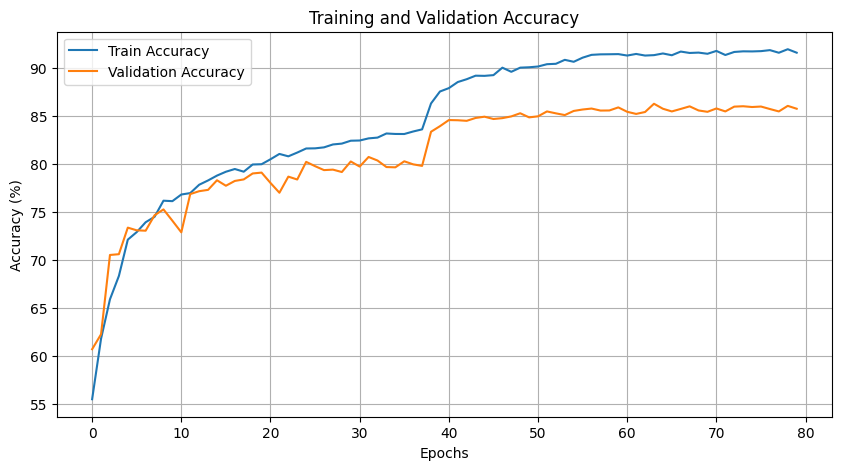

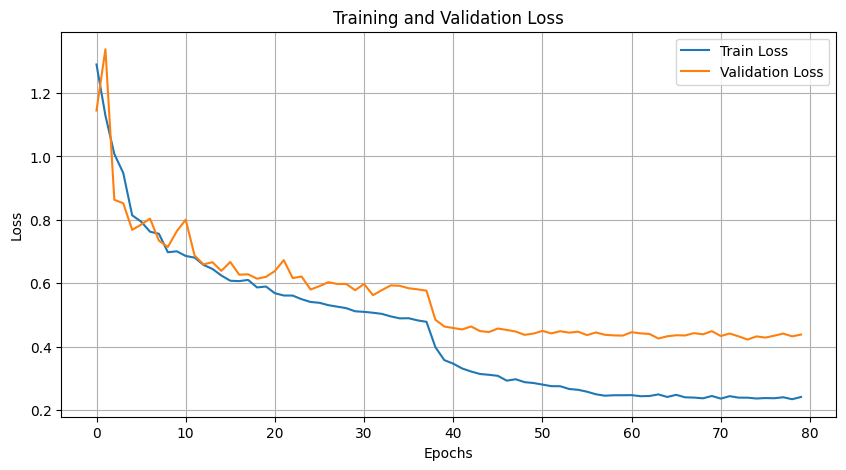

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()
